# Preprocess the Model for Ratio Reconstruction

### TO DO:
Have some simple tests that check data when loading. Leverage existing reading tools but add project specific checks later
*

In [2]:
from climpyrical.data import read_data, gen_dataset, interpolate_dataset
from climpyrical.gridding import regrid_ensemble, extend_north
from climpyrical.mask import stratify_coords
from pkg_resources import resource_filename

import pickle
import xarray as xr
import numpy as np
from scipy.interpolate import LinearNDInterpolator, NearestNDInterpolator
import geopandas as gpd

import matplotlib.pyplot as plt
import matplotlib

import os

font = {'weight' : 'bold',
        'size'   : 28}

matplotlib.rc('font', **font)
plt.rcParams['figure.figsize'] = (10, 10)

%load_ext autoreload
%autoreload 2

TJan2.5
TJan1.0
TJul97.5
TwJul97.5
HDD
Tmax
Tmin
R15m10
R1d50
PAnn
RAnn
MI
SL50
RL50
WP10
WP50
DRWP5
RHann

## Interpolate the model

In [3]:
# Establish paths dictionary

# station_dv = 'RL50 (kPa)'
# station_dv = 'mean RH (%)'
# station_dv = 'HDD (degC-day)'
# station_dv = 'SL50 (kPa)'
# station_dv = 'TJan2.5 (degC)'
# station_dv = 'TJan1.0 (degC)'
# station_dv = 'Q10_Gumbel-MM'
# station_dv = 'Q50_Gumbel-MM'
# station_dv = 'Tmin (degC)'
# station_dv = 'Tmax (degC)'
# station_dv = 'TJul2.5 (degC)'
# station_dv = 'TwJul2.5 (degC)'
# station_dv = 'DRWP-RL5 (Pa)'
station_dv = 'annual_pr (mm)'
# station_dv = 'annual_rain (mm)'

with open('station_dv.pickle', 'wb') as outfile:
    pickle.dump(station_dv, outfile)
    print("Pickled station dv: ", station_dv)

paths = {
    'RL50 (kPa)': 'nrc_data/snw_rain_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc',
    'mean RH (%)': 'nrc_data/hurs_CanRCM4-LE_ens15_1951-2016_ensmean.nc',
    'HDD (degC-day)': 'nrc_data/hdd_CanRCM4-LE_ens35_1951-2016_ann_ensmean.nc',
    'SL50 (kPa)': 'nrc_data/snw_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc',
    'Q10_Gumbel-MM': 'nrc_data/wpress_CanRCM4-LE_ens35_1951-2016_max_rl10_kpa_ensmean.nc',
    'Q50_Gumbel-MM': 'nrc_data/wpress_CanRCM4-LE_ens35_1951-2016_max_rl50_kpa_ensmean.nc',
    'TJan2.5 (degC)': 'nrc_data/tas_CanRCM4-LE_ens35_1951-2016_1hr_jan2.5p_ensmean.nc',
    'TJan1.0 (degC)': 'nrc_data/tas_CanRCM4-LE_ens35_1951-2016_1hr_jan1.0p_ensmean.nc',
    'Tmax (degC)': 'nrc_data/tas_CanRCM4-LE_ens35_1951-2016_ann_max_ensmean.nc',
    'Tmin (degC)': 'nrc_data/tas_CanRCM4-LE_ens35_1951-2016_ann_min_ensmean.nc',
    'TwJul2.5 (degC)': 'nrc_data/twb_CanRCM4-LE_ens35_1951-2016_1hr_jul97.5p_ensmean.nc',
    'TJul2.5 (degC)': 'nrc_data/tas_CanRCM4-LE_ens35_1951-2016_1hr_jul97.5p_ensmean.nc',
    'DRWP-RL5 (Pa)': 'nrc_data/DRWP_CanRCM4-LE_ens15_1951-2016_RL5_ensmean.nc',
    'annual_pr (mm)': 'nrc_data/pr_CanRCM4-LE_ens35_1951-2016_ann_sum_ensmean.nc',
    'annual_rain (mm)': 'nrc_data/rain_CanRCM4-LE_ens35_1951-2016_ann_sum_ensmean.nc'
}

filenames = {
    'RL50 (kPa)': 'RL50',
    'mean RH (%)': 'RHann',
    'HDD (degC-day)': 'HDD',
    'SL50 (kPa)': 'SL50',
    'Q10_Gumbel-MM': 'WP10',
    'Q50_Gumbel-MM': 'WP50',
    'TJan2.5 (degC)': 'TJan2.5',
    'TJan1.0 (degC)': 'TJan1.0',
    'Tmin (degC)': 'Tmin',
    'Tmax (degC)': 'Tmax',
    'TJul2.5 (degC)': 'TJul97.5',
    'TwJul2.5 (degC)': 'TwJul97.5',
    'DRWP-RL5 (Pa)': 'DRWP5',
    'annual_pr (mm)': 'PAnn',
    'annual_rain (mm)': 'RAnn'
}

file_dv = filenames[station_dv]

PATH_MEAN_SNOW = resource_filename(
    'climpyrical', 
    'nrc_data/snw_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc'
)

PATH_MEAN = resource_filename(
    'climpyrical',
    paths[station_dv]
)

ds_mean = read_data(PATH_MEAN)
dv = list(ds_mean.data_vars)[0]
print(dv)

Pickled station dv:  annual_pr (mm)
pr


In [4]:
# Create coordinate grids
rlon, rlat = np.meshgrid(ds_mean.rlon, ds_mean.rlat)

Load the Surface to Land Fraction Mask `sftlf`

In [5]:
PATH_MASK = resource_filename('climpyrical', 'nrc_data/land_mask_CanRCM4_sftlf.nc')
PATH_GLACIER_MASK = resource_filename('climpyrical', 'nrc_data/glacier_mask.nc')

# load mask data
mask = read_data(PATH_MASK)

# regrid dataset to target resolution
mask = regrid_ensemble(mask, 'sftlf', 10, copy=True)

# convert to boolean mask
mask = mask['sftlf'] >= 1.0

Use regridded mask to reference the new coordinates on the map

In [6]:
# Create array of mean
if 'degC' in station_dv and not 'degC-day' in station_dv:
    mean = ds_mean[dv].values + 273.15
else:
    mean = ds_mean[dv].values

mask_og = read_data(PATH_MASK)['sftlf'].values != 0.0
glaciermask = read_data(PATH_GLACIER_MASK)['mask'].values

fill_glaciers = True
if fill_glaciers:
    mean[glaciermask] = np.nan

nanmask = ~np.isnan(mean)
points = np.stack([rlon[nanmask], rlat[nanmask]]).T
target_values = mean[nanmask]
target_points = np.stack([rlon[glaciermask], rlat[glaciermask]]).T

mean[glaciermask] = interpolate_dataset(points, target_values, target_points, 'linear')
ds_mean_glacier_filled = gen_dataset(dv, mean, ds_mean.rlon, ds_mean.rlat)

In [7]:
# send to DVE
regrid_ensemble(ds_mean_glacier_filled, dv, 10, copy=True, keys=['rlat', 'rlon']).to_netcdf(f'~/dash-dv-explorer/assets/data/ensemble/{file_dv}_10_ensemble_mean.nc')

In [8]:
path_shapefile = resource_filename('climpyrical', 'nrc_data/canada_final.shp')
canada = gpd.read_file(path_shapefile).geometry
X, Y = stratify_coords(canada)

/home/nannau/11042020/climpyrical/climpyrical/mask.py:55: UserWarning: Neither init or datum found in proj4 data. Please provide initial                         reference projection with Polygon.crs = "epsg:4326"
  warnings.warn(


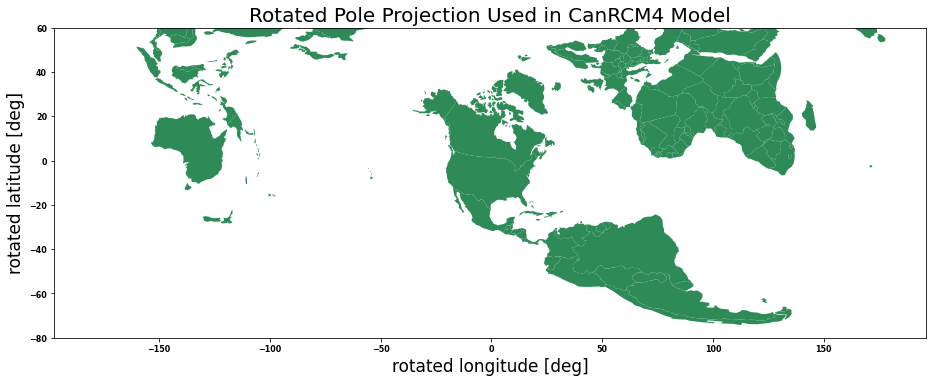

In [37]:
from climpyrical.mask import rotate_shapefile

font = {'weight' : 'bold',
        'size'   : 8}

matplotlib.rc('font', **font)
plt.rcParams['figure.figsize'] = (13, 13)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
rotated_world = rotate_shapefile(world)
rotated_world = rotated_world[(rotated_world.name != 'Russia') & (rotated_world.continent != "Antarctica")]
rotated_world.plot(color = 'seagreen')
plt.ylim(-80, 60)
plt.xlabel('rotated longitude [deg]', fontsize=17)
plt.ylabel('rotated latitude [deg]', fontsize=17)
plt.plot()
plt.title('Rotated Pole Projection Used in CanRCM4 Model', fontsize=20)
plt.tight_layout()

plt.savefig('/home/nannau/Desktop/rotated_pole_world.png')

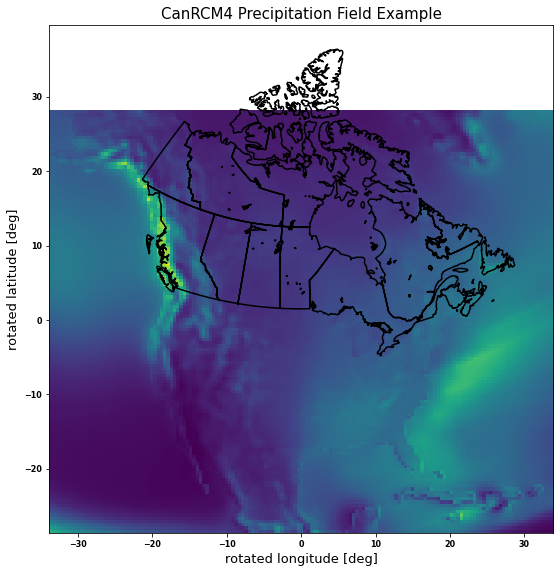

In [44]:
plt.figure(figsize=(8, 8))
plt.imshow(ds_mean_glacier_filled[dv], origin='lower', extent=[ds_mean_glacier_filled.rlon.min(), ds_mean_glacier_filled.rlon.max(), ds_mean_glacier_filled.rlat.min(), ds_mean_glacier_filled.rlat.max()])
plt.plot(X, Y, color='black')
plt.xlabel('rotated longitude [deg]', fontsize=13)
plt.ylabel('rotated latitude [deg]', fontsize=13)
plt.plot()
plt.title('CanRCM4 Precipitation Field Example', fontsize=15)
plt.tight_layout()
plt.savefig('/home/nannau/Desktop/CanRCM4_rotated_pole')

# Mask out ocean values

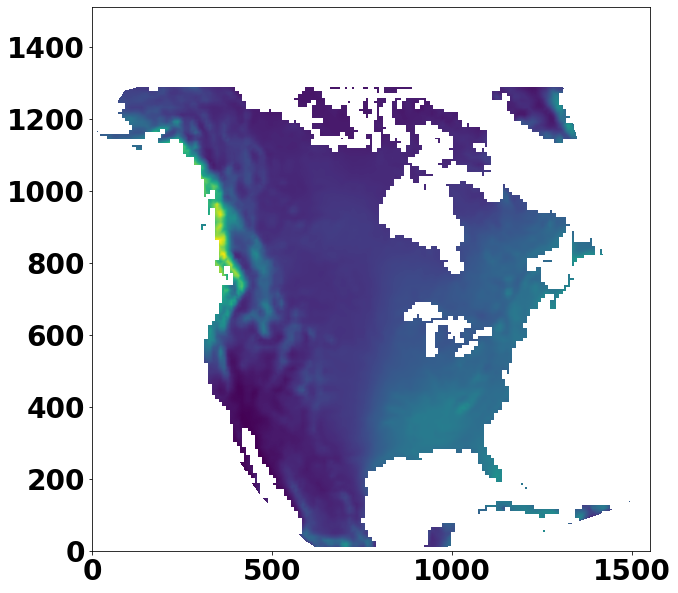

In [9]:
# make all water values NaN at original resolution
ds_mean_glacier_filled[dv].values[~mask_og] = np.nan
rlon, rlat = np.meshgrid(ds_mean_glacier_filled.rlon, ds_mean_glacier_filled.rlat)
nanmask = ~np.isnan(ds_mean_glacier_filled[dv].values)

# copy newly masked dv field to target resolution
ds10_cp = regrid_ensemble(ds_mean_glacier_filled, dv, 10, copy=True, keys=['rlat', 'rlon'])
# Mask out ocean values
ds10_cp[dv].values[~mask] = np.nan

nrlon, nrlat = np.meshgrid(ds10_cp.rlon, ds10_cp.rlat)
nanmask10 = ~np.isnan(ds10_cp[dv].values)


# bilinearly interpolate over non NaN grids
points = np.stack([rlon[nanmask], rlat[nanmask]]).T
target_points = np.stack([nrlon[nanmask10], nrlat[nanmask10]]).T
target_values = ds_mean_glacier_filled[dv].values[nanmask]
ds10_cp[dv].values[nanmask10] = interpolate_dataset(points, target_values, target_points, 'linear')

# extend the northern region 
ds10_cp_ext = extend_north(ds10_cp, dv, 210, fill_val=np.nan)

# create nanmask for interpolation
nanmask10 = ~np.isnan(ds10_cp_ext[dv].values)
ds_mean10_nx = ds10_cp_ext.copy()

plt.figure(figsize=(10, 10))
plt.imshow(ds10_cp_ext[dv].values, origin='lower')


Load final refined mask. If not accessible, or desire difference shapefile, follow `mask.ipynb`

(1510, 1550)


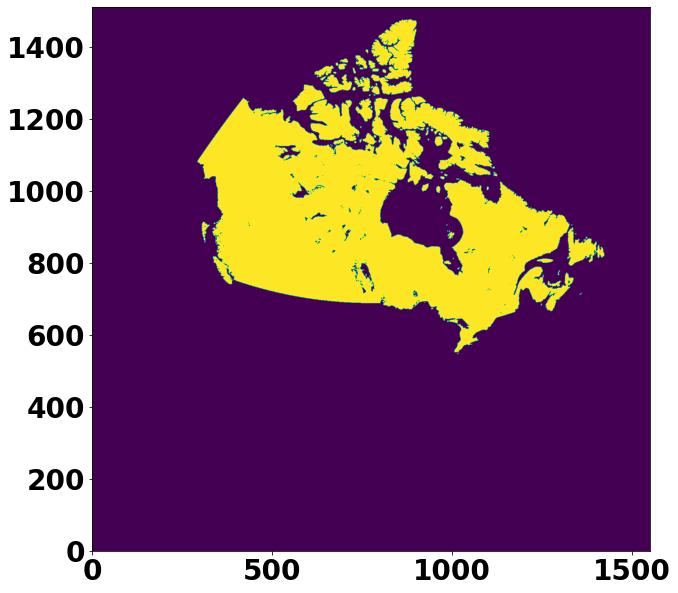

In [10]:
mask_path = resource_filename('climpyrical', '/nrc_data/processed/canada_mask_rp.nc')

with read_data(mask_path) as ds:
    print(ds['mask'].shape)
    rmask = extend_north(ds, 'mask', 210, fill_val=np.nan)
    rmask = ds['mask'].values

plt.imshow(rmask, origin='lower')

Find inconsistent areas between the refined mask and the model by comparing model values with refined mask values

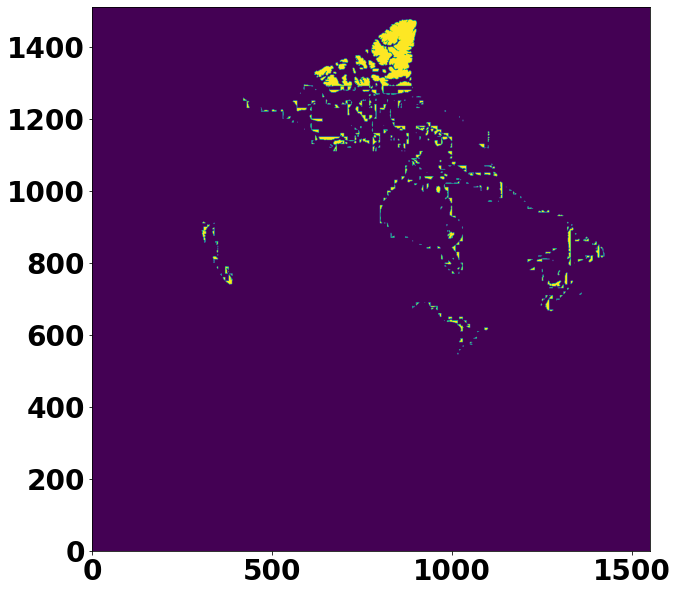

In [11]:
nanmask10 = ~np.isnan(ds_mean10_nx[dv])
rmask_or = ~np.logical_or(~rmask, nanmask10)

plt.imshow(rmask_or, origin='lower')

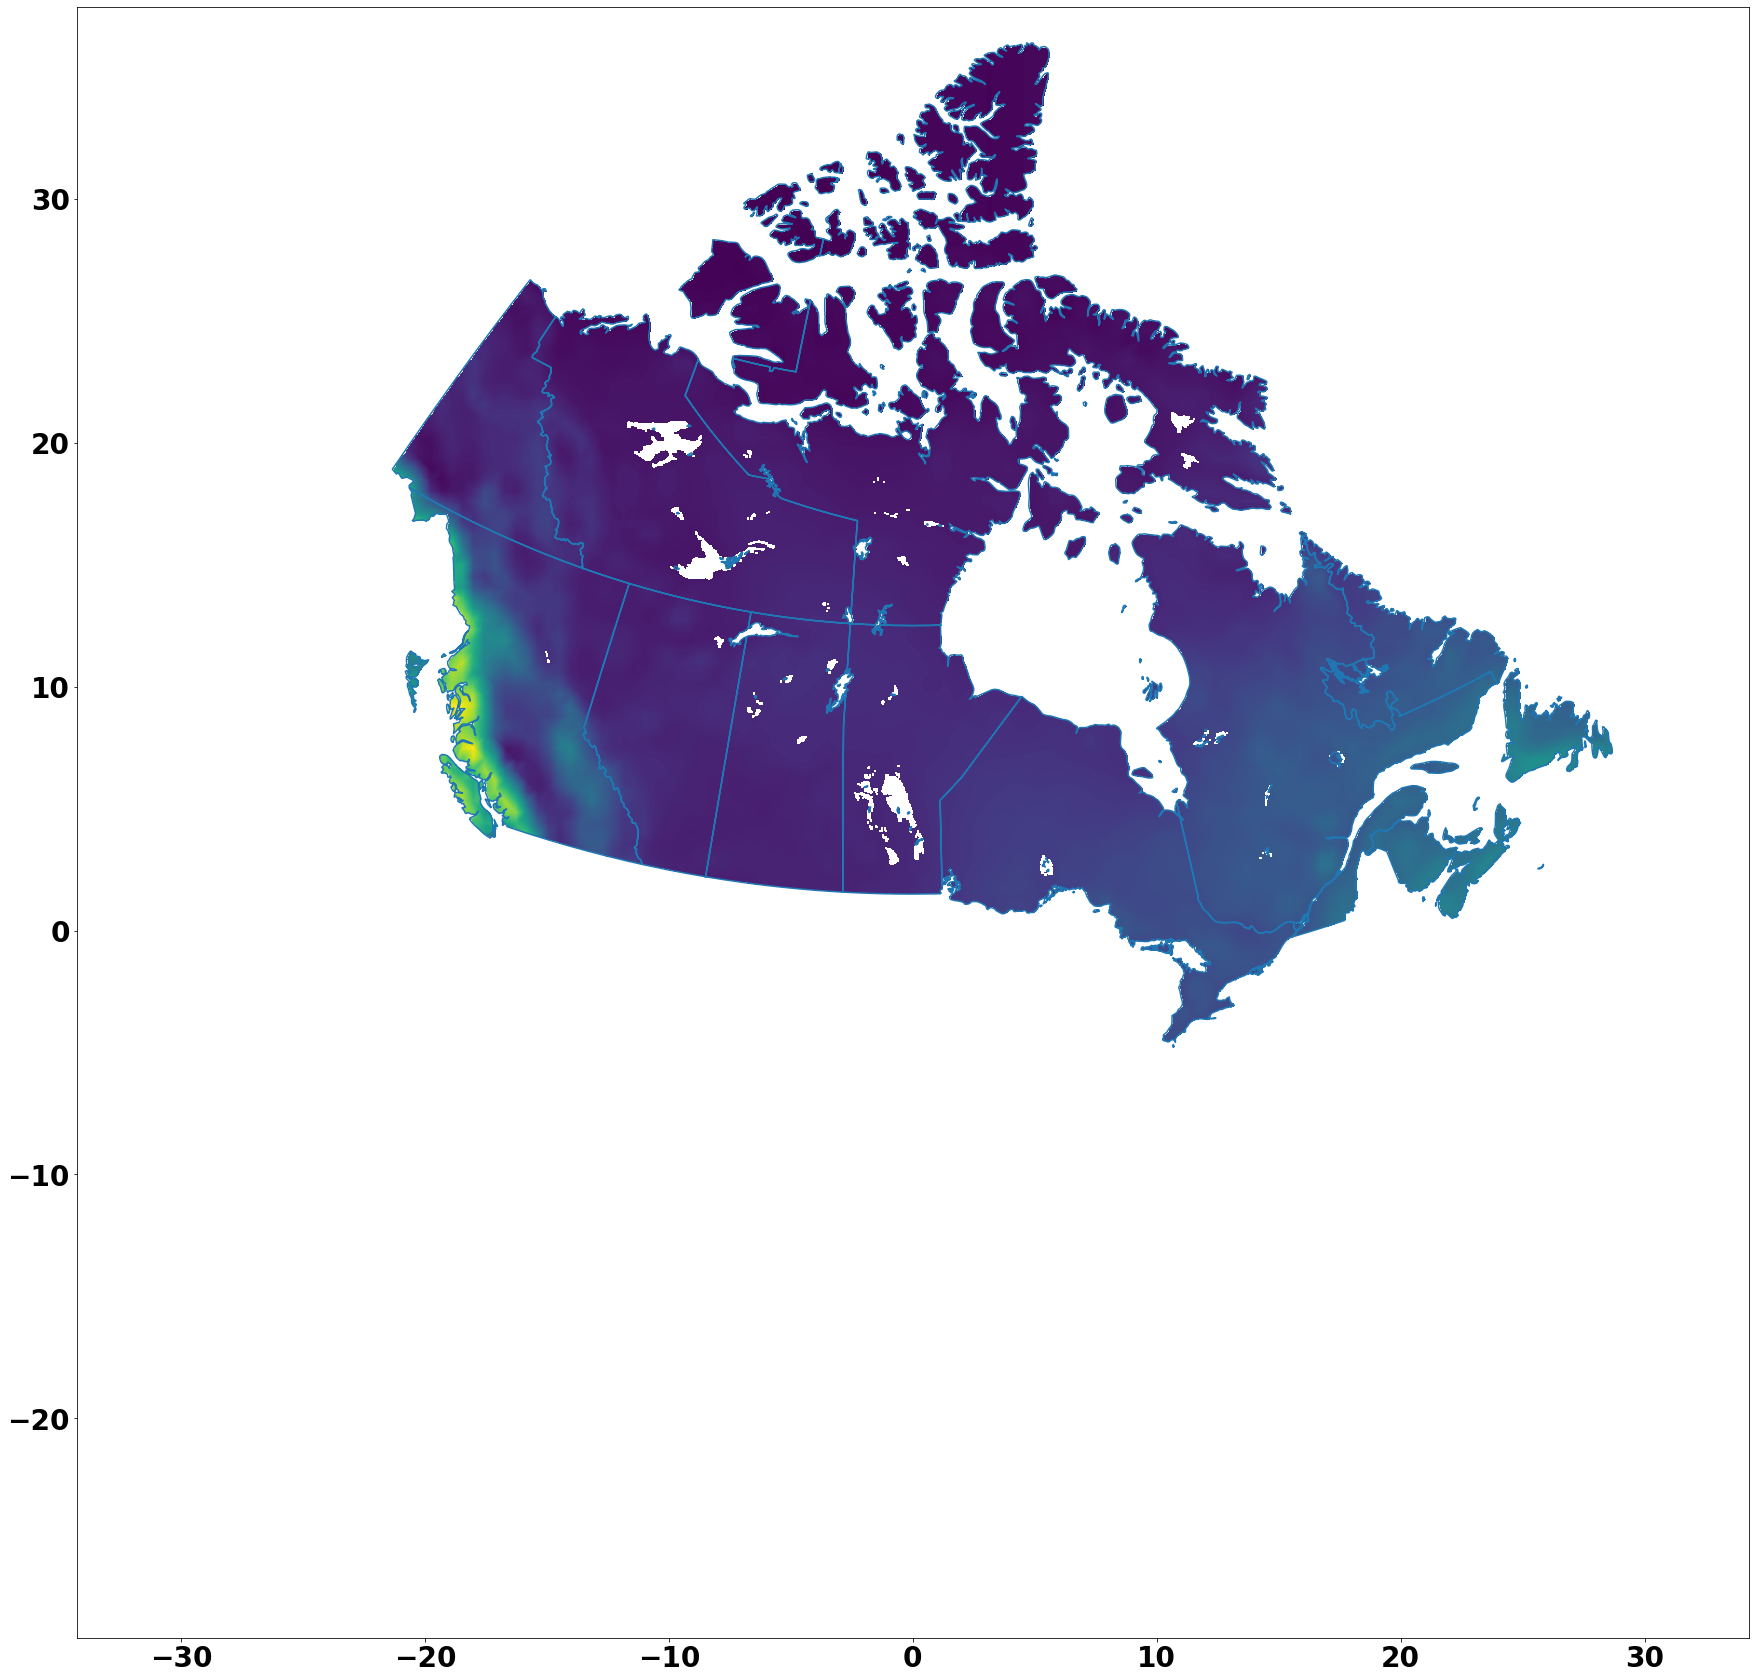

In [12]:
# Fill inconsistent points using closest neighbour.
# Not that the northern section will be filled later on
nrlon, nrlat = np.meshgrid(ds10_cp_ext.rlon.values, ds10_cp_ext.rlat.values)

temp_field = ds_mean10_nx[dv].values

points = np.stack([nrlon[nanmask10], nrlat[nanmask10]]).T
f = NearestNDInterpolator(points, ds_mean10_nx[dv].values[nanmask10])
temp_field[rmask_or] = f(np.stack([nrlon[rmask_or], nrlat[rmask_or]]).T)
temp_field[~rmask] = np.nan

mean10_ext_f = xr.Dataset(
    {dv: (["rlat", "rlon"], temp_field)},
    coords={"rlon": ("rlon", ds_mean10_nx.rlon), "rlat": ("rlat", ds_mean10_nx.rlat)},
)

plt.figure(figsize=(30, 30))
extent = [ds.rlon.min(), ds.rlon.max(), ds.rlat.min(), ds.rlat.max()]

plt.imshow(mean10_ext_f[dv], origin='lower', extent=extent)
X, Y = stratify_coords(canada)
extent = [ds.rlon.min(), ds.rlon.max(), ds.rlat.min(), ds.rlat.max()]

path_shapefile = resource_filename('climpyrical', 'nrc_data/canada_final.shp')
canada = gpd.read_file(path_shapefile).geometry
plt.plot(X, Y)

In [13]:
# Check all inconsistencies are filled
assert ~np.any(~np.logical_or(~rmask, ~np.isnan(mean10_ext_f[dv]))).values
mean10_ext_f.rlon

<xarray.DataArray 'rlon' (rlon: 1550)>
array([-34.276005, -34.231749, -34.187494, ...,  34.187494,  34.231749,
        34.276005])
Coordinates:
  * rlon     (rlon) float64 -34.28 -34.23 -34.19 -34.14 ... 34.19 34.23 34.28

In [14]:
# # find NaN values in ensemble mean
# mean_glacier_filled = mean10_ext_f[dv].values
# nanmask = ~np.isnan(mean10_ext_f[dv].values)
# print(nanmask.shape)
# # create interpolator for non NaN values
# # new coordinates to interpolate to (ds10_cp_ext is at target resolution)
# nrlon, nrlat = np.meshgrid(mean10_ext_f.rlon.values, mean10_ext_f.rlat.values)

# points = np.stack([nrlon[nanmask], nrlat[nanmask]]).T
# target_points = np.stack([nrlon[nanmask], nrlat[nanmask]]).T

# mean10 = mean10_ext_f[dv].values
# mean10[nanmask] = interpolate_dataset(points, mean_glacier_filled[nanmask], target_points, 'linear')

# ds_mean10_nx = gen_dataset(dv, mean10, mean10_ext_f.rlon.values, mean10_ext_f.rlat.values)

# plt.figure(figsize=(30, 30))
# plt.imshow(ds_mean10_nx[dv], origin='lower')

In [15]:
pre_processed_path = resource_filename(
    "climpyrical", 
    f"/nrc_data/processed/{file_dv}_pre_processed.nc"
)

if os.path.exists(pre_processed_path):
    os.remove(pre_processed_path)
    mean10_ext_f.to_netcdf(pre_processed_path, 'w')
else:
    mean10_ext_f.to_netcdf(pre_processed_path, 'w')

In [16]:
mean10_ext_f

<xarray.Dataset>
Dimensions:  (rlat: 1510, rlon: 1550)
Coordinates:
  * rlon     (rlon) float64 -34.28 -34.23 -34.19 -34.14 ... 34.19 34.23 34.28
  * rlat     (rlat) float64 -29.0 -28.95 -28.91 -28.86 ... 37.77 37.82 37.86
Data variables:
    pr       (rlat, rlon) float64 nan nan nan nan nan ... nan nan nan nan nan